In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from folium import Map, Circle, Marker, Icon
from random import randint
from shapely.geometry import Point

In [2]:
# importing the data
boston_df = pd.read_csv('boston_corrected_corrected.csv')
boston_gdf  = gpd.GeoDataFrame(boston_df, geometry=gpd.points_from_xy(boston_df.LAT, boston_df.LON))
boston_gdf.drop('Unnamed: 0', axis=1, inplace=True)

hospital_df = pd.read_csv('massachusetts-hospitals.csv')
hospital_gdf  = gpd.GeoDataFrame(hospital_df, geometry=gpd.points_from_xy(hospital_df.SHAPE_Y, hospital_df.SHAPE_X))
hospital_gdf = hospital_gdf.geometry

school_df = pd.read_csv('massachusetts-schools-pre-k-through-high-school_new.csv')
school_gdf  = gpd.GeoDataFrame(school_df, geometry=gpd.points_from_xy(school_df.SHAPE_Y, school_df.SHAPE_X))
school_gdf = school_gdf.geometry

uni_gdf = gpd.read_file('University_data\GISDATA_COLLEGES_PTPoint.shp')
uni_gdf = uni_gdf.geometry
uni_gdf = uni_gdf.apply(lambda row: Point(row.y, row.x))

train_gdf = gpd.read_file('Train_data\GISDATA_TRAINS_NODEPoint.shp')
train_gdf = train_gdf.geometry
train_gdf = train_gdf.apply(lambda row: Point(row.y, row.x))

chc_gdf = gpd.read_file('Community_Health_Center_data\GISDATA_CHCS_PTPoint.shp')
chc_gdf = chc_gdf.geometry
chc_gdf = chc_gdf.apply(lambda row: Point(row.y, row.x))

# setting the crs of files saved as .csv
boston_gdf.set_crs(epsg=4326, inplace=True)
hospital_gdf.set_crs(epsg=4326, inplace=True)
school_gdf.set_crs(epsg=4326, inplace=True)

# project from degrees to meters
boston_gdf = boston_gdf.to_crs(epsg=900913)
hospital_gdf = hospital_gdf.to_crs(epsg=900913)
school_gdf = school_gdf.to_crs(epsg=900913)
uni_gdf = uni_gdf.to_crs(epsg=900913)
train_gdf = train_gdf.to_crs(epsg=900913)
chc_gdf = chc_gdf.to_crs(epsg=900913)

## Checking and cleaning the data

This data frame contains the following columns:

* TOWN a factor with levels given by town names
    * Should all be strings
    * All have capital letter at the beginning of each word

* TOWNNO a numeric vector corresponding to TOWN
    * Should be int
    * Should be same number as number of unique town names

* TRACT a numeric vector of tract ID numbers
    * Should be int
    * Should be >= 0

* LON a numeric vector of tract point longitudes in decimal degrees
    * Should be float
    * Should be between -180 and 180

* LAT a numeric vector of tract point latitudes in decimal degrees
    * Should be float
    * Should be between -90 and 90

* MEDV a numeric vector of median values of owner-occupied housing in USD 1000
    * Should be float

* CMEDV a numeric vector of corrected median values of owner-occupied housing in USD 1000
    * Should be float

* CRIM a numeric vector of per capita crime
    * Should be float

* ZN a numeric vector of proportions of residential land zoned for lots over 25000 sq. ft per town (constant for all Boston tracts)
    * Should be float

* INDUS a numeric vector of proportions of non-retail business acres per town (constant for all Boston tracts)
    * Should be float

* CHAS a factor with levels 1 if tract borders Charles River; 0 otherwise
    * Should be int

* NOX a numeric vector of nitric oxides concentration (parts per 10 million) per town
    * Should be float

* RM a numeric vector of average numbers of rooms per dwelling
    * Should be float

* AGE a numeric vector of proportions of owner-occupied units built prior to 1940
    * Should be float

* DIS a numeric vector of weighted distances to five Boston employment centres
    * Should be float

* RAD a numeric vector of an index of accessibility to radial highways per town (constant for all Boston tracts)
    * Should be float

* TAX a numeric vector full-value property-tax rate per USD 10,000 per town (constant for all Boston tracts)
    * Should be float

* PTRATIO a numeric vector of pupil-teacher ratios per town (constant for all Boston tracts)
    * Should be float

* B a numeric vector of 1000*(Bk - 0.63)^2 where Bk is the proportion of blacks
    * Should be float

* LSTAT a numeric vector of percentage values of lower status population
    * Should be float

Adapted from: https://nowosad.github.io/spData/reference/boston.html

### Checking that there are no null values and that dtypes are as expected

In [3]:
boston_gdf.head()

TOWN  TOWNNO  TRACT        LON        LAT  MEDV  CMEDV     CRIM  \
0      Nahant       0   2011 -70.927800  42.426000  24.0   24.0  0.00632   
1  Swampscott       1   2021 -70.919764  42.481455  21.6   21.6  0.02731   
2  Swampscott       1   2022 -70.897264  42.473777  34.7   34.7  0.02729   
3  Marblehead       2   2031 -70.884407  42.490840  33.4   33.4  0.03237   
4  Marblehead       2   2032 -70.874764  42.499371  36.2   36.2  0.06905   

     ZN  INDUS  ...    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO       B  \
0  18.0   2.31  ...  0.538  6.575  65.2  4.0900    1  296     15.3  396.90   
1   0.0   7.07  ...  0.469  6.421  78.9  4.9671    2  242     17.8  396.90   
2   0.0   7.07  ...  0.469  7.185  61.1  4.9671    2  242     17.8  392.83   
3   0.0   2.18  ...  0.458  6.998  45.8  6.0622    3  222     18.7  394.63   
4   0.0   2.18  ...  0.458  7.147  54.2  6.0622    3  222     18.7  396.90   

   LSTAT                           geometry  
0   4.98  POINT (4722840.716 -11377630.320)  
1   9.14  POINT (4729013.939 -11374893.260)  
2   4.03  POINT (4728159.185 -11367235.395)  
3   2.94  POINT (4730058.638 -11362863.369)  
4   5.33  POINT (4731008.364 -11359586.207)  

[5 rows x 21 columns]

In [4]:
hospital_gdf.head()

0    POINT (4747466.578 -11520167.009)
1    POINT (4726668.629 -11423315.492)
2    POINT (4690267.283 -11585327.833)
3    POINT (4703181.401 -11678411.837)
4    POINT (4713250.615 -11438366.700)
Name: geometry, dtype: geometry

In [5]:
school_gdf.head()

0    POINT (4636965.302 -11379009.899)
1    POINT (4683594.326 -11989720.535)
2    POINT (4678235.601 -11478672.516)
3    POINT (4722150.287 -11409416.711)
4    POINT (4719271.669 -11414830.330)
Name: geometry, dtype: geometry

In [6]:
uni_gdf.head()

0    POINT (4688963.487 -11974293.409)
1    POINT (4690322.055 -11737696.573)
2    POINT (4690165.217 -12046083.251)
3    POINT (4691105.651 -11951920.520)
4    POINT (4691191.197 -11973019.927)
Name: geometry, dtype: geometry

In [7]:
train_gdf.head()

0    POINT (4656409.119 -11545086.256)
1    POINT (4644960.832 -11555266.180)
2    POINT (4766385.674 -11441276.682)
3    POINT (4762342.543 -11432706.794)
4    POINT (4690906.409 -11580898.730)
Name: geometry, dtype: geometry

In [8]:
chc_gdf.head()

0    POINT (4752170.841 -11453943.454)
1    POINT (4714155.422 -11424506.661)
2    POINT (4696904.504 -12263057.239)
3    POINT (4714657.473 -11424050.416)
4    POINT (4645848.910 -11445585.258)
Name: geometry, dtype: geometry

In [9]:
boston_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   TOWN      506 non-null    object  
 1   TOWNNO    506 non-null    int64   
 2   TRACT     506 non-null    int64   
 3   LON       506 non-null    float64 
 4   LAT       506 non-null    float64 
 5   MEDV      506 non-null    float64 
 6   CMEDV     506 non-null    float64 
 7   CRIM      506 non-null    float64 
 8   ZN        506 non-null    float64 
 9   INDUS     506 non-null    float64 
 10  CHAS      506 non-null    int64   
 11  NOX       506 non-null    float64 
 12  RM        506 non-null    float64 
 13  AGE       506 non-null    float64 
 14  DIS       506 non-null    float64 
 15  RAD       506 non-null    int64   
 16  TAX       506 non-null    int64   
 17  PTRATIO   506 non-null    float64 
 18  B         506 non-null    float64 
 19  LSTAT     506 non-null    float64 
 20  ge

In [10]:
sorted(boston_gdf.TOWN.unique())

['Arlington',
 'Ashland',
 'Bedford',
 'Belmont',
 'Beverly',
 'Boston Allston-Brighton',
 'Boston Back Bay',
 'Boston Beacon Hill',
 'Boston Charlestown',
 'Boston Dorchester',
 'Boston Downtown',
 'Boston East Boston',
 'Boston Forest Hills',
 'Boston Hyde Park',
 'Boston Mattapan',
 'Boston North End',
 'Boston Roxbury',
 'Boston Savin Hill',
 'Boston South Boston',
 'Boston West Roxbury',
 'Braintree',
 'Brookline',
 'Burlington',
 'Cambridge',
 'Canton',
 'Chelsea',
 'Cohasset',
 'Concord',
 'Danvers',
 'Dedham',
 'Dover',
 'Duxbury',
 'Everett',
 'Framingham',
 'Hamilton',
 'Hanover',
 'Hingham',
 'Holbrook',
 'Hull',
 'Lexington',
 'Lincoln',
 'Lynn',
 'Lynnfield',
 'Malden',
 'Manchester',
 'Marblehead',
 'Marshfield',
 'Medfield',
 'Medford',
 'Melrose',
 'Middleton',
 'Millis',
 'Milton',
 'Nahant',
 'Natick',
 'Needham',
 'Newton',
 'Norfolk',
 'North Reading',
 'Norwell',
 'Norwood',
 'Peabody',
 'Pembroke',
 'Quincy',
 'Randolph',
 'Reading',
 'Revere',
 'Rockland',
 'Sale

### Check that the characteristics of each column are as expected as defined above

In [11]:
assert len(boston_gdf.TOWN.unique()) == len(boston_gdf.TOWNNO.unique()), 'Number of unique town names must be equal to number of unique town numbers'
assert all(boston_gdf.TRACT) >= 0, 'ID numbers must be greater than or equal to zero'
assert -180 <= all(boston_gdf.LON) <= 180, 'Longitude must be between -180 and 180'
assert -90 <= all(boston_gdf.LAT) <= 90, 'Latitude must be between -90 and 90'

### Dropping the MEDV column as CMEDV will be used as our target variable and we do not want data leakage

In [12]:
boston_gdf.drop('MEDV', axis=1, inplace=True)

### Dropping TOWN because it repeats information in TOWNNO

In [13]:
boston_gdf.drop('TOWN', axis=1, inplace=True)

## Feature engineering

### Visualizing the geospatial data
* Houses are represented by circles coloured by town.
* Hospitals, schools, universities, train stations, and health centres are represented by icons.

In [14]:
print('INITIALIZING MAP')
m_2 = Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=13)
print('MAP INITIALIZED')

boston_4326 = boston_gdf.to_crs(epsg=4326)
hospital_4326 = hospital_gdf.to_crs(epsg=4326)
school_4326 = school_gdf.to_crs(epsg=4326)
uni_4326 = uni_gdf.to_crs(epsg=4326)
train_4326 = train_gdf.to_crs(epsg=4326)
chc_4326 = chc_gdf.to_crs(epsg=4326)

colors = []
for _ in range(boston_gdf['TOWNNO'].nunique()):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

print('ADDING HOUSES TO MAP')
for i in range(len(boston_gdf)):
    if i == 8:
        Circle(
            location=[boston_gdf.iloc[i]['LAT'], boston_gdf.iloc[i]['LON']],
            radius=1000,
            color=colors[boston_gdf.iloc[i]['TOWNNO']],
            popup='House '+str(i)+'\n'+str(boston_4326.geometry.iloc[i])).add_to(m_2)
    else:
        Circle(
            location=[boston_gdf.iloc[i]['LAT'], boston_gdf.iloc[i]['LON']],
            radius=10,
            color=colors[boston_gdf.iloc[i]['TOWNNO']],
            popup='House '+str(i)+'\n'+str(boston_4326.geometry.iloc[i])).add_to(m_2)
print('COMPLETE')

print('ADDING HOSPITALS TO MAP')
for i in range(len(hospital_gdf)):
    Marker(
        location=[hospital_4326.iloc[i].x, hospital_4326.iloc[i].y],
        popup = 'Hospital',
        icon=Icon(color="red",icon="h-square", prefix='fa')).add_to(m_2)
print('COMPLETE')
    
print('ADDING SCHOOLS TO MAP')
for i in range(len(school_gdf)):
    Marker(
        location=[school_4326.iloc[i].x, school_4326.iloc[i].y],
        popup='School',
        icon=Icon(color="blue",icon="graduation-cap", prefix='fa')).add_to(m_2)  
print('COMPLETE')

print('ADDING UNIVERSITIES TO MAP')
for i in range(len(uni_gdf)):
    Marker(
        location=[uni_4326.iloc[i].x, uni_4326.iloc[i].y],
        popup='University',
        icon=Icon(color="black",icon="graduation-cap", prefix='fa')).add_to(m_2)  
print('COMPLETE')

print('ADDING TRAIN STATIONS TO MAP')
for i in range(len(train_gdf)):
    Marker(
        location=[train_4326.iloc[i].x, train_4326.iloc[i].y],
        popup='Train station',
        icon=Icon(color="green",icon="train", prefix='fa')).add_to(m_2)  
print('COMPLETE')

print('ADDING HEALTH CENTRES TO MAP')
for i in range(len(chc_gdf)):
    Marker(
        location=[chc_4326.iloc[i].x, chc_4326.iloc[i].y],
        popup='Health Centre',
        icon=Icon(color="orange",icon="medkit", prefix='fa')).add_to(m_2)  
print('COMPLETE')

import io
from PIL import Image

m_2.save(outfile= "map.html")

m_2

INITIALIZING MAP
MAP INITIALIZED
ADDING HOUSES TO MAP
COMPLETE
ADDING HOSPITALS TO MAP
COMPLETE
ADDING SCHOOLS TO MAP
COMPLETE
ADDING UNIVERSITIES TO MAP
COMPLETE
ADDING TRAIN STATIONS TO MAP
COMPLETE
ADDING HEALTH CENTRES TO MAP
COMPLETE


### Creating new features
* Calculating distances to nearest utilities
* Calculating number of each utility in a 10km radius

In [15]:
print('CALCULATING DISTANCES TO NEAREST HOSPITALS')
boston_gdf['dist_nearest_hospital'] = [np.inf for _ in range(len(boston_gdf))]
for hospital in hospital_gdf:
    boston_gdf['dist_nearest_hospital'] = [min(a,b) for a,b in zip(boston_gdf['dist_nearest_hospital'],
                                              boston_gdf.geometry.distance(hospital))]
print('COMPLETE')
print('CALCULATING DISTANCES TO NEAREST SCHOOLS')
boston_gdf['dist_nearest_school'] = [np.inf for _ in range(len(boston_gdf))]
for school in school_gdf:
    dist_to_school = boston_gdf.geometry.apply(lambda x: school.distance(x))
    boston_gdf['dist_nearest_school'] = [min(a,b) for a,b in zip(boston_gdf['dist_nearest_school'], dist_to_school)]
print('COMPLETE')
print('CALCULATING DISTANCES TO NEAREST UNIVERSITIES')    
boston_gdf['dist_nearest_uni'] = [np.inf for _ in range(len(boston_gdf))]
for uni in uni_gdf:
    dist_to_uni = boston_gdf.geometry.apply(lambda x: uni.distance(x))
    boston_gdf['dist_nearest_uni'] = [min(a,b) for a,b in zip(boston_gdf['dist_nearest_uni'], dist_to_uni)]
print('COMPLETE')
print('CALCULATING DISTANCES TO NEAREST TRAIN STATIONS')
boston_gdf['dist_nearest_train_station'] = [np.inf for _ in range(len(boston_gdf))]
for train in train_gdf:
    dist_to_train_station = boston_gdf.geometry.apply(lambda x: train.distance(x))
    boston_gdf['dist_nearest_train_station'] = [min(a,b) for a,b in zip(boston_gdf['dist_nearest_train_station'], 
                                                                        dist_to_train_station)]
print('COMPLETE')
boston_gdf['dist_nearest_health_centre'] = [np.inf for _ in range(len(boston_gdf))]
print('CALCULATING DISTANCES TO NEAREST HEALTH CENTRES')
for chc in chc_gdf:
    dist_to_chc = boston_gdf.geometry.apply(lambda x: chc.distance(x))
    boston_gdf['dist_nearest_health_centre'] = [min(a,b) for a,b in zip(boston_gdf['dist_nearest_health_centre'], 
                                                                        dist_to_chc)]
print('COMPLETE')

CALCULATING DISTANCES TO NEAREST HOSPITALS
COMPLETE
CALCULATING DISTANCES TO NEAREST SCHOOLS
COMPLETE
CALCULATING DISTANCES TO NEAREST UNIVERSITIES
COMPLETE
CALCULATING DISTANCES TO NEAREST TRAIN STATIONS
COMPLETE
CALCULATING DISTANCES TO NEAREST HEALTH CENTRES
COMPLETE


In [16]:
ten_km_buffers = boston_gdf.geometry.buffer(10000)
number_of_hospitals_within_10km = list()
number_of_schools_within_10km = list()
number_of_unis_within_10km = list()
number_of_train_stations_within_10km = list()
number_of_health_centres_within_10km = list()
for idx, ten_km_buffer in enumerate(ten_km_buffers):
    hospital_count = len(hospital_gdf.loc[hospital_gdf.apply(lambda x: ten_km_buffer.contains(x))])
    number_of_hospitals_within_10km.append(hospital_count)
    school_count = len(school_gdf.loc[school_gdf.apply(lambda x: ten_km_buffer.contains(x))])
    number_of_schools_within_10km.append(school_count)
    uni_count = len(uni_gdf.loc[uni_gdf.apply(lambda x: ten_km_buffer.contains(x))])
    number_of_unis_within_10km.append(uni_count)
    train_station_count = len(train_gdf.loc[train_gdf.apply(lambda x: ten_km_buffer.contains(x))])
    number_of_train_stations_within_10km.append(train_station_count)
    chc_count = len(chc_gdf.loc[chc_gdf.apply(lambda x: ten_km_buffer.contains(x))])
    number_of_health_centres_within_10km.append(chc_count)
boston_gdf['hospitals_within_10km'] = number_of_hospitals_within_10km
boston_gdf['schools_within_10km'] = number_of_schools_within_10km
boston_gdf['unis_within_10km'] = number_of_unis_within_10km
boston_gdf['train_stations_within_10km'] = number_of_train_stations_within_10km
boston_gdf['health_centres_within_10km'] = number_of_health_centres_within_10km

### Distribution of new features

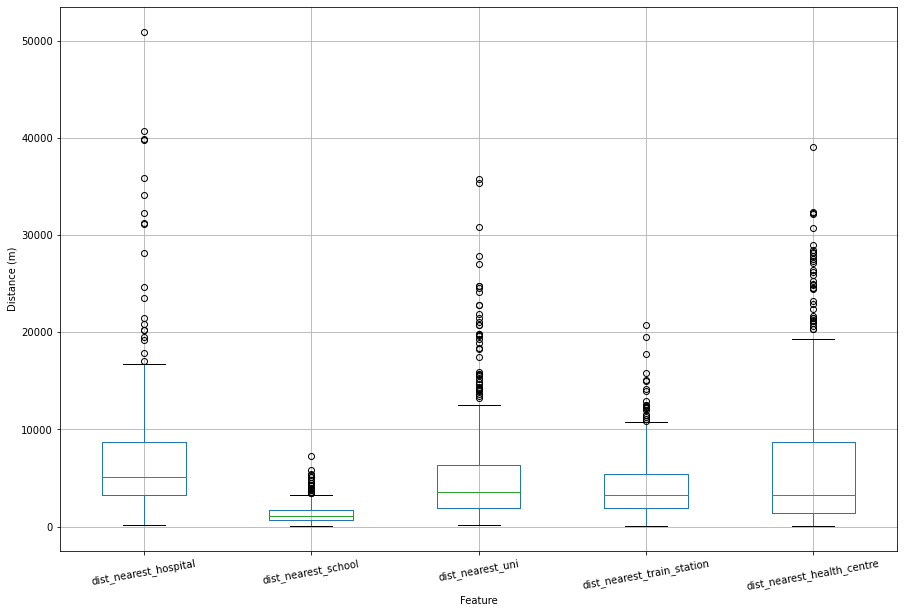

In [17]:
plt.figure(figsize=(15,10))
boston_gdf.iloc[:,-10:-5].boxplot(rot=10)
plt.xlabel('Feature')
plt.ylabel('Distance (m)')
plt.savefig('new_feature_dist_boxplot.png')
plt.show()

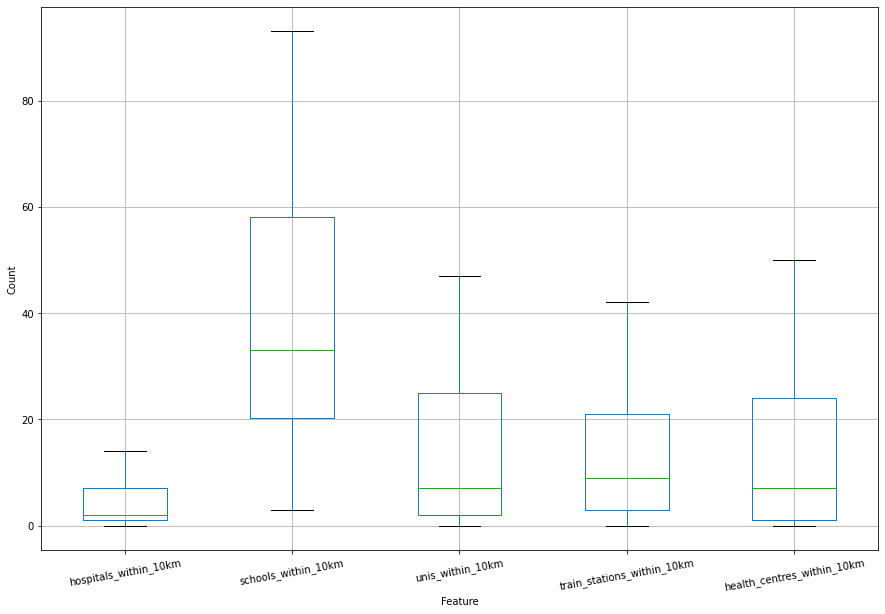

In [18]:
plt.figure(figsize=(15,10))
boston_gdf.iloc[:,-5:].boxplot(rot=10)
plt.xlabel('Feature')
plt.ylabel('Count')
plt.savefig('new_feature_count_boxplot.png')
plt.show()

### Seperate explanatory variables from target and split into train and test set (80:20), will be using cross-validation on training set

In [19]:
X = boston_gdf.copy()
y = X.pop('CMEDV')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

### Calculate a mutual information score to understand how knowledge of one quantity reduces uncertainty about the target variable

* 0 means that the quantities are independent
* The higher the score the better
* Scores > 2 are uncommon as mutual information score increases slowly as it is a logarithmic quantity

In [20]:
mi_scores = mutual_info_regression(X.loc[:, X.columns != 'geometry'], y, random_state=2021)
mi_scores_series = pd.Series(mi_scores, name="MI Scores", index=X.loc[:, X.columns != 'geometry'].columns).sort_values(ascending=False)

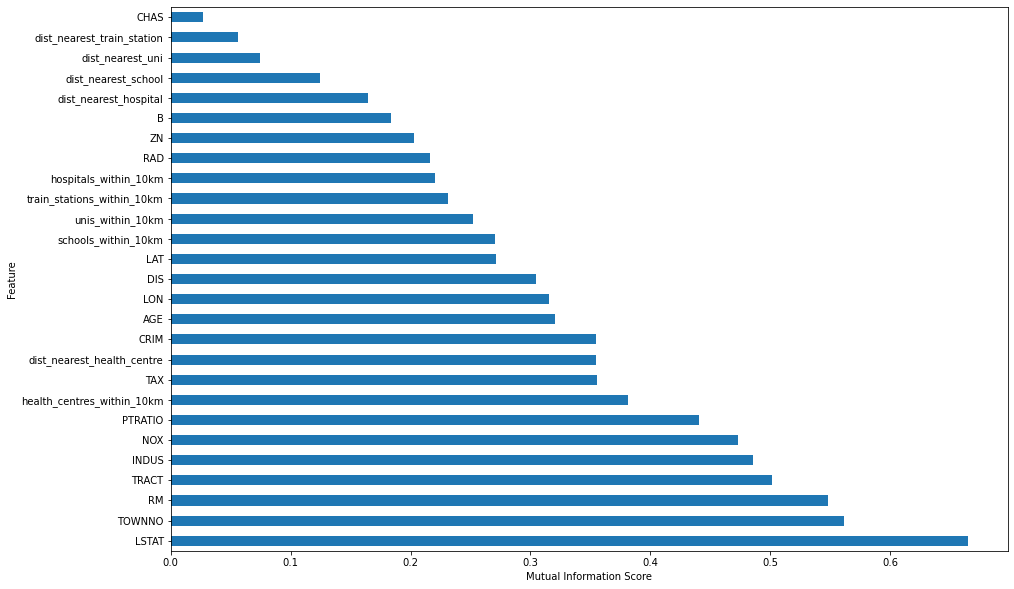

In [21]:
plt.figure(figsize=(15,10))
mi_scores_series.plot.barh()
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.savefig('mutual_info_score.png', bbox_inches='tight')
plt.show()

In [22]:
top_ten_features = mi_scores_series[:10].index
top_ten_features

Index(['LSTAT', 'TOWNNO', 'RM', 'TRACT', 'INDUS', 'NOX', 'PTRATIO',
       'health_centres_within_10km', 'TAX', 'dist_nearest_health_centre'],
      dtype='object')

### Correlation coefficients

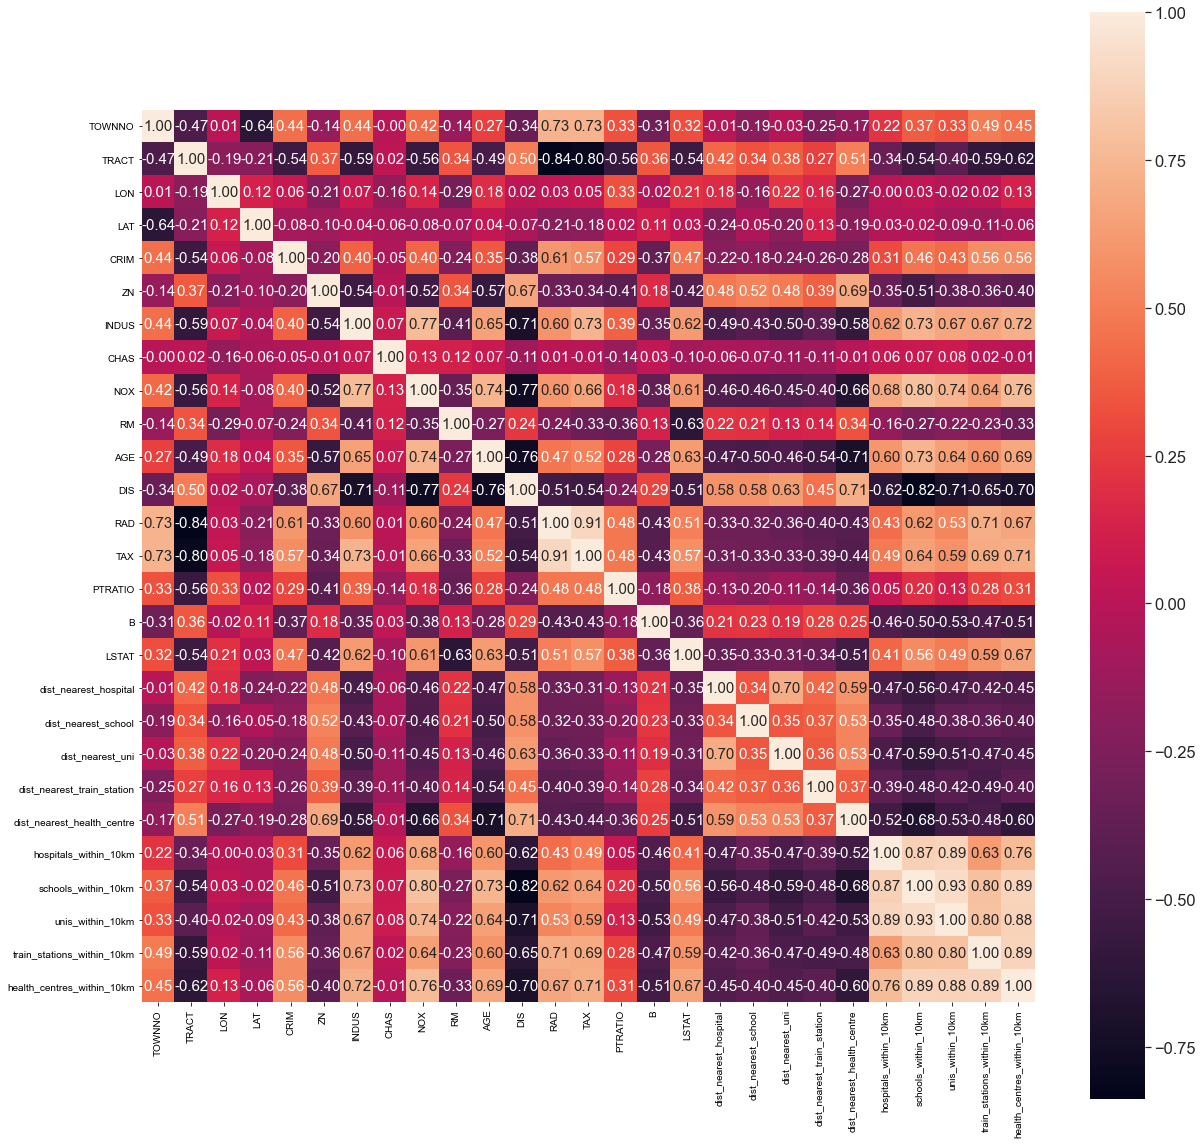

In [23]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(20,20))
cm = np.corrcoef(X_train.loc[:, X.columns != 'geometry'].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=X_train.loc[:, X.columns != 'geometry'].columns,
                xticklabels=X_train.loc[:, X.columns != 'geometry'].columns,
                ax=ax)
plt.savefig('corr_matrix.png', facecolor='white', bbox_inches='tight')
plt.show()

### Normalizing data using StandardScaler()

In [24]:
x_scaler = StandardScaler()
X_train_sc = x_scaler.fit_transform(X_train.loc[:, X.columns != 'geometry'])
X_test_sc = x_scaler.transform(X_test.loc[:, X.columns != 'geometry'])

x_scaler_10 = StandardScaler()
X_train_sc_10 = x_scaler_10.fit_transform(X_train.loc[:,top_ten_features])
X_test_sc_10 = x_scaler_10.transform(X_test.loc[:,top_ten_features])

### Principle Component Analysis (PCA)

In [25]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_sc)

component_names = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=component_names)

X_train_pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.592169 -1.567638 -2.433406 -0.105538 -0.387097  0.589586 -1.034879   
1  0.522804  0.443594 -1.967311 -0.502300 -1.030430  0.738146 -0.331798   
2  6.202802  2.611079  2.433676  0.795704  0.192090  0.073673  0.339062   
3 -6.834923  2.462134 -0.535876  1.048299  1.845484 -1.432973  1.402394   
4 -2.412303 -1.879322 -0.546341  1.703364 -0.323037 -0.736768  0.710437   

        PC8       PC9      PC10  ...      PC18      PC19      PC20      PC21  \
0  0.820184  0.447229  0.497247  ...  0.264961  0.048535 -0.413437  0.228939   
1 -1.076535 -0.319578 -1.456050  ... -0.595753 -0.212549  0.445180 -0.542730   
2 -0.348030  0.046429 -2.411681  ...  0.674821 -0.601432 -0.356325  0.197441   
3  2.290267  0.501016 -1.052237  ... -0.078485 -0.115414  0.158145 -0.222268   
4 -0.343933  0.171424  0.328034  ... -0.347438  0.635454  0.234714  0.055836   

       PC22      PC23      PC24      PC25      PC26      PC27  
0  0.205390  0.088666  0.326061  0.148005  0.134731 -0.049723  
1  0.255802  0.698315 -0.166789 -0.144051  0.232521 -0.042361  
2  0.227267 -0.001949  0.376907 -0.015684  0.247009 -0.164595  
3 -0.146130 -0.086061 -0.327313  0.056323  0.002737 -0.177649  
4  0.991950 -0.228528 -0.304686 -0.282793 -0.015611  0.056963  

[5 rows x 27 columns]

In [26]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X_train.loc[:, X.columns != 'geometry'].columns,  # and the rows are the original features
)
loadings = pd.concat([loadings, pd.DataFrame(X_train.loc[:, X.columns != 'geometry'].columns, columns=['col_names'], index=X_train.loc[:, X.columns != 'geometry'].columns)], axis=1)

In [27]:
loadings.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
TOWNNO -0.145278  0.435395  0.126408 -0.169619 -0.219165 -0.031494 -0.049614   
TRACT   0.209572 -0.158193  0.199041  0.227130 -0.280391 -0.260100  0.011756   
LON    -0.030929  0.082181 -0.449494  0.369517 -0.229805  0.323268 -0.151907   
LAT     0.009097 -0.352073 -0.303994  0.006827  0.474541  0.275526  0.008097   
CRIM   -0.164969  0.225657  0.005105 -0.019993  0.254437  0.032058  0.024837   

             PC8       PC9      PC10  ...      PC19      PC20      PC21  \
TOWNNO -0.192948 -0.028688 -0.107438  ... -0.144423  0.346388 -0.253786   
TRACT  -0.013905 -0.030680  0.032997  ...  0.130071  0.026994 -0.045710   
LON     0.052886  0.092337  0.130613  ... -0.170435  0.079788 -0.165872   
LAT     0.131309  0.129243 -0.029682  ... -0.001139  0.156267 -0.132531   
CRIM    0.192712  0.400219 -0.263577  ...  0.059504 -0.006473  0.003783   

            PC22      PC23      PC24      PC25      PC26      PC27  col_names  
TOWNNO  0.046567  0.490929 -0.313096 -0.089383 -0.038858  0.110894     TOWNNO  
TRACT  -0.444638 -0.113270 -0.249260  0.070673 -0.224477  0.493371      TRACT  
LON    -0.104011 -0.099188  0.009277  0.000081 -0.041278 -0.013065        LON  
LAT    -0.139967  0.235090 -0.288044 -0.043596 -0.121967  0.227451        LAT  
CRIM    0.004193  0.020286 -0.021528  0.008298  0.034299 -0.010969       CRIM  

[5 rows x 28 columns]

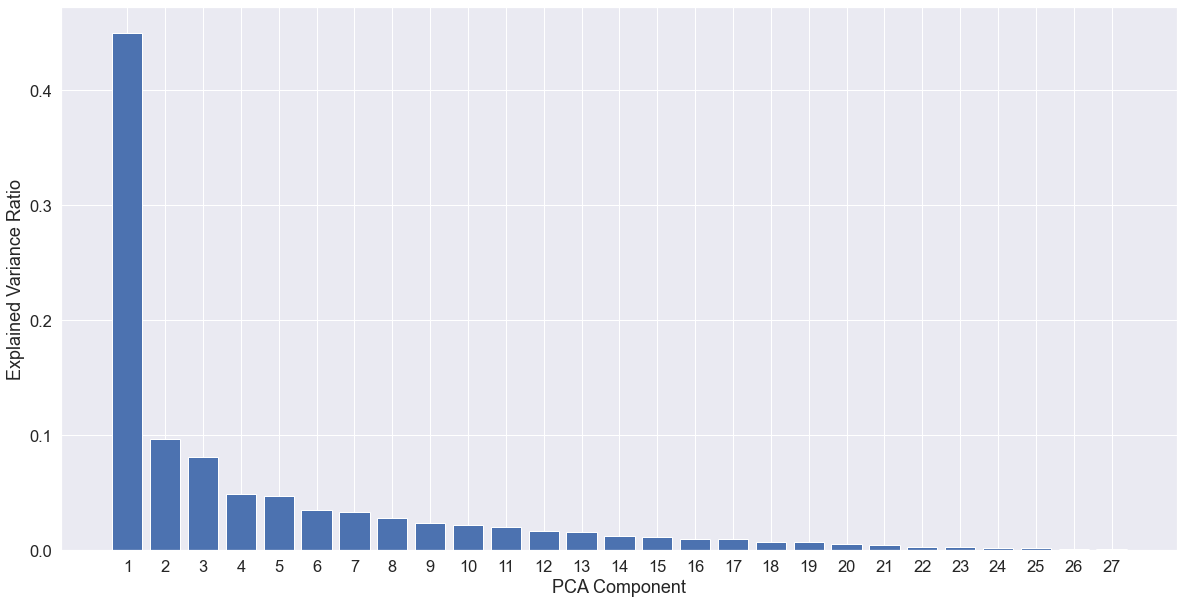

In [28]:
plt.figure(figsize=(20,10))
plt.bar(range(1,len(component_names)+1), pca.explained_variance_ratio_)
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(ticks=range(1,len(component_names)+1), labels=range(1,len(component_names)+1))
plt.savefig('all_pca.png', bbox_inches='tight')
plt.show()

<Figure size 4320x2880 with 0 Axes>

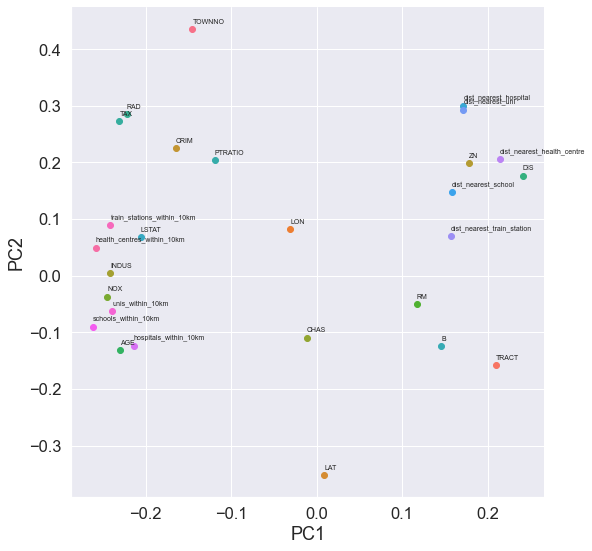

In [29]:
plt.figure(figsize=(60,40))
fg = sns.FacetGrid(data=loadings, hue='col_names', hue_order=X_train.loc[:, X.columns != 'geometry'].columns, height=8)
fg.map(plt.scatter, 'PC1', 'PC2')#.add_legend(ncol=1)
for x, y, label in zip(loadings.PC1, loadings.PC2, loadings.col_names):
    plt.text(x=x, y=y+0.01, s=label, size=7)
plt.savefig('pc2vpc1.png')
plt.show()

### Regression models

In [30]:
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor

C:\Users\Jemima\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [31]:
def mean_absolute_percentage_error(true, predicted):
    return np.mean(abs((true-predicted)/true))*100

In [32]:
def mean_scoring(results, model_name):
    train_RMSE = np.mean(np.sqrt(results['train_MSE']*-1))
    test_RMSE = np.mean(np.sqrt(results['test_MSE']*-1))
    train_MAPE = np.mean(results['train_MAPE']*-1)
    test_MAPE = np.mean(results['test_MAPE']*-1)
    scoring_means = {'train_RMSE':[train_RMSE], 'test_RMSE':[test_RMSE], 'train_MAPE':[train_MAPE], 
                     'test_MAPE':[test_MAPE]}
    scoring_means_df = pd.DataFrame(scoring_means, index=[model_name])
    return scoring_means_df

In [33]:
scoring = {'MSE':'neg_mean_squared_error', 'MAPE':make_scorer(mean_absolute_percentage_error, greater_is_better=False)}

In [34]:
benchmark_model = LinearRegression(n_jobs=-1)
cv_benchmark = cross_validate(benchmark_model, X_train_sc, y_train, scoring=scoring, n_jobs=-1, return_train_score=True,
                              return_estimator=True)
linear_scoring_df = mean_scoring(cv_benchmark, 'Linear')

In [35]:
alphas_en = np.linspace(0.1,1,10)
best_alpha_en = None
best_RMSE = np.inf
for alpha in alphas_en:
    elastic_net_model = ElasticNet()
    cv_en = cross_validate(elastic_net_model, X_train_sc, y_train, scoring=scoring, n_jobs=-1, 
                             return_train_score=True, return_estimator=True)
    en_scoring_df = mean_scoring(cv_en, 'EN')
    best_RMSE = min(best_RMSE, en_scoring_df.test_RMSE.iloc[0])
    if best_RMSE == en_scoring_df.test_RMSE.iloc[0]:
        best_alpha_en = alpha
elastic_net_model = ElasticNet(alpha=best_alpha_en)
cv_elastic_net = cross_validate(elastic_net_model, X_train_sc, y_train, scoring=scoring, n_jobs=-1, return_train_score=True,
                              return_estimator=True)
elastic_net_scoring_df = mean_scoring(cv_elastic_net, 'Elastic Net')

In [36]:
alphas_tree = np.linspace(0,1,11)
best_alpha_tree = None
best_RMSE = np.inf
for alpha in alphas_tree:
    tree_model = DecisionTreeRegressor(random_state=2021, ccp_alpha=alpha)
    cv_tree = cross_validate(tree_model, X_train_sc, y_train, scoring=scoring, n_jobs=-1, return_train_score=True,
                                  return_estimator=True)
    tree_scoring_df = mean_scoring(cv_tree, 'Tree')
    best_RMSE = min(best_RMSE, tree_scoring_df.test_RMSE.iloc[0])
    if best_RMSE == tree_scoring_df.test_RMSE.iloc[0]:
        best_alpha_tree = alpha
tree_model = DecisionTreeRegressor(random_state=2021, ccp_alpha=best_alpha_tree)
cv_tree = cross_validate(tree_model, X_train_sc, y_train, scoring=scoring, n_jobs=-1, return_train_score=True,
                              return_estimator=True)
tree_scoring_df = mean_scoring(cv_tree, 'Decision Tree Regression')

In [37]:
alphas_tree = np.linspace(0,1,11)
best_alpha_tree = None
best_RMSE = np.inf
for alpha in alphas_tree:
    tree_model = DecisionTreeRegressor(random_state=2021, ccp_alpha=alpha)
    cv_tree = cross_validate(tree_model, X_train_sc_10, y_train, scoring=scoring, 
                             n_jobs=-1, return_train_score=True, return_estimator=True)
    fs_tree_scoring_df = mean_scoring(cv_tree, 'Tree')
    best_RMSE = min(best_RMSE, fs_tree_scoring_df.test_RMSE.iloc[0])
    if best_RMSE == fs_tree_scoring_df.test_RMSE.iloc[0]:
        best_alpha_tree = alpha
tree_model = DecisionTreeRegressor(random_state=2021, ccp_alpha=best_alpha_tree)
cv_tree = cross_validate(tree_model, X_train_sc_10, y_train, scoring=scoring, n_jobs=-1, 
                         return_train_score=True, return_estimator=True)
fs_tree_scoring_df = mean_scoring(cv_tree, 'Feature Selection Decision Tree Regression')

In [38]:
scoring_df = pd.concat([linear_scoring_df, elastic_net_scoring_df, tree_scoring_df, fs_tree_scoring_df])

In [39]:
display(scoring_df)

train_RMSE  test_RMSE  train_MAPE  \
Linear                                        4.258474   4.692458   16.266513   
Elastic Net                                   5.428836   5.466787   18.330701   
Decision Tree Regression                      2.475156   4.852431   10.355333   
Feature Selection Decision Tree Regression    1.750009   4.035640    7.429926   

                                            test_MAPE  
Linear                                      18.297933  
Elastic Net                                 18.784390  
Decision Tree Regression                    17.039425  
Feature Selection Decision Tree Regression  14.764868